In [5]:
import matplotlib.pyplot as plt
import polars as pl
import pandas as pd
import os
import sys

sys.path.append("..")

from settings import (
    random_state,
    PROJECT_PATH,
    REGRESSION_TARGET,
    CLASSIFICATION_TARGET,
)
from sklearn.ensemble import RandomForestRegressor
import shap
from shap import TreeExplainer


In [14]:
transactions = pl.read_parquet(
    os.path.join(PROJECT_PATH, "transactions_post_feature_engineering.parquet")
)

selected_region = "nom_region_Occitanie"
region_transactions = transactions.filter(pl.col(selected_region) == 1)

X = region_transactions.drop([REGRESSION_TARGET, CLASSIFICATION_TARGET]).to_pandas()
y_regression = region_transactions[REGRESSION_TARGET].to_pandas()

In [15]:
feature_names_simplified = [
    "surface_habitable",
    "prix_m2_moyen_mois_precedent",
    "longitude",
    "latitude",
    "nb_transactions_mois_precedent",
    "type_batiment_Appartement",
]

In [16]:
rf_regressor_light = RandomForestRegressor(random_state=random_state)
rf_regressor_light.fit(X[feature_names_simplified], y_regression)

RandomForestRegressor(random_state=42)

In [23]:
explainer = TreeExplainer(rf_regressor_light, approximate=True)
shap_values = explainer(X[feature_names_simplified])

Voici la valeur de référence que SHAP utilsie pour le calcul des valeurs de Shapley 

In [27]:

explainer.expected_value

array([127597.1438447])

In [20]:
y_pred = rf_regressor_light.predict(X[feature_names_simplified])

absolute_errors_train = pd.Series(
    [
        abs(true_value - predicted_value)
        for (true_value, predicted_value) in zip(y_regression, y_pred)
    ]
)

Ici, nous voyons que l'erreur moyenne de notre modèle est aux alentours de 11k€. Les interprétations des valeurs de Shapley de cet ordre de grandeur sont à prendre avec beaucoup de pincettes, car on ne saurait pas faire la différence entre un effet avéré de la feature et l'erreur d'estimation. 

In [21]:
print(absolute_errors_train.describe().apply(lambda x: format(x, "f")))

count     50982.000000
mean      10924.996767
std       16886.158663
min           0.000000
25%        2682.100000
50%        6333.200000
75%       13237.383750
max      774482.200000
dtype: object


Le Dependency Plot ci-dessous nous permets  interpréter le lien entre la variable "surface_habitable" et les valeurs de Shapley, tout en corrélant avec une 3eme variable, afin de détécter des tendances de comportement plus complexes qu'avec le graphique Beeswarm !

Le graphique montre la dispersion des valeurs de Shapley pour différentes valeurs de "surface_habitable".  Nous pouvons observer que les valeurs de Shapley pour la variable "surface_habitable" sont principalement positives, ce qui indique une influence positive de cette feature sur la prédiction du modèle. Ce lien semble linéaire en plus, ce qui signifie que des valeurs plus élevées de "surface_habitable" sont généralement associées à des prédictions de prix plus élevées. Une interprétation tout à fait cohérente avec la réalité métier de l'immobilier. 

Dans cette tendance linéaire, on ne voit pas de groupes distincts de comportements se dégager concernant la deuxième feature "prix_m2_moyen_mois_precdent". La corrélation en question est alors purement numérique et ne reflète pas de réalité métier particulière.

Cependant, il y a aussi quelques observations avec des valeurs de Shapley négatives, ce qui suggère une influence négative de la feature "surface_habitable" sur la prédiction du modèle. Cela peut être dû à des outilers, ou bien à l'effet des autres features du modèle, invisible ici. 

C'est en effet la limite de ce type de graphique, on visualise les valeurs de Shapley et 2 features, en supposant que toutes les autres features sont figés, ce qui est une hypothèse très forte comme les corrélations avec les autres features ne doivent pas être ignorées.

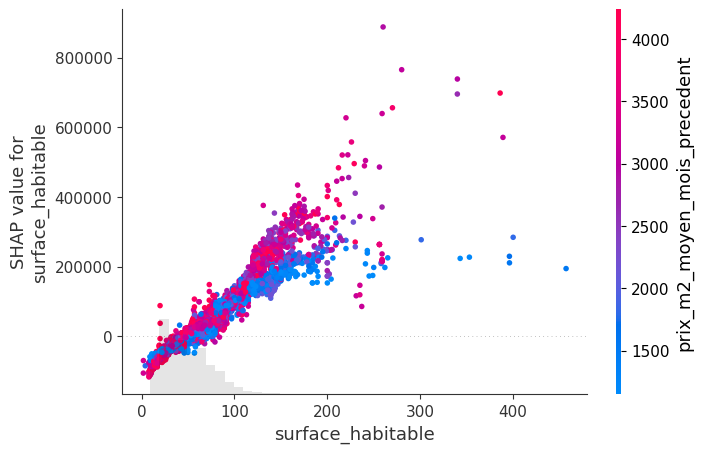

In [24]:
shap.plots.scatter(shap_values[:, "surface_habitable"], color=shap_values)

Dans ce graphique en revanche, Nous ne pouvons quasiment rien déduire : 
* En effet, quel que soit les valeurs prises par la feature "nb_transactions_mois_precdent", nous avons la même amplitude des valeurs de Shapley qui se situe globallement entre -50k€ et 50k€
* La 2eme feature n'aide pas non plus a expliquer pourquoi dans certain cas la contribution de la 1ere feature est positve et pourquoi dans d'autres cas elle est négative 
* Les effets observés sont probablement dus à d'autres features qu'on ne visualise pas ici

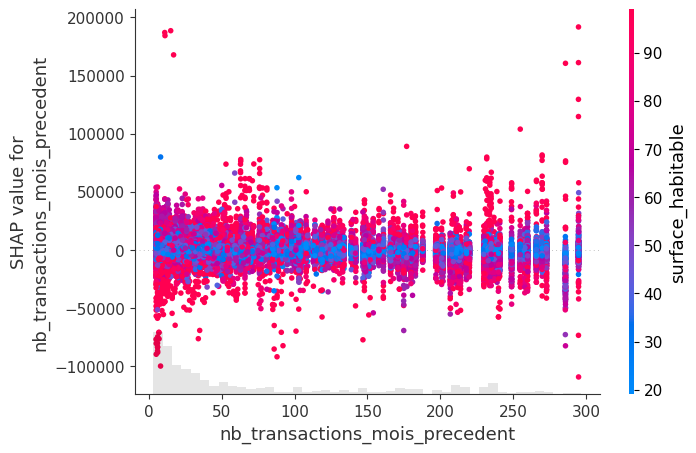

In [26]:

shap.plots.scatter(shap_values[:, "nb_transactions_mois_precedent"], color=shap_values)